# DeepPhilaOD
Predicting Opioid epidemic progression using incidicence maps generated from EMS radio audio 

In [4]:
# Import dependencies

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

import matplotlib.pyplot as plt
import random

import os

import os,sys
import h5py
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import applications
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
from tqdm import tqdm
from PIL import Image
from keras.applications.mobilenet import preprocess_input


## Build model

In [5]:
# Load pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_____________________________________

In [6]:
#-Transfer learning

from keras.layers import Conv1D

# Freeze all InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# Get output tensors to prepare for adding layers
x = base_model.output

# Add a few Dense and Dropout layers for initial "learning"
for i in range(10):
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)

# Hope for feature selection when weights are adjusted in the fitting/ retraining
for i in range(10):
    x = Conv2D (kernel_size = (200), filters = 20, activation='relu')(x)
    x = MaxPooling2D(pool_size = (1,10), strides=(1,2))(x)
    
# Final predictive layer -- supposed to be 47 predictions, one for value per zip code
# --total is 87 zip codes, but bug from above, so only 5 (otherwise model won't build)
predictions = Dense(5, activation='relu')(x)

# this is the model we will train
deepPhilaOD = Model(inputs=base_model.input, outputs=predictions)

# compile to allow for fitting with new data
deepPhilaOD.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


- Note: not very sure which line or call resulted in the message above, but the model builds
- Future work: debug and continue optimizing

## Training and testing

In [69]:
# Initiate list of zip codes (47 as shown in most zip-code-maps)
zips = [19142, 19128, 19118, 19140, 19148, 19102, 19152, 19154, 19145,    
          +19120 , 19141 , 19149, 19136, 19114, 19115, 19146, 19130, 19107, 19122, 19106, 
          +19143, 19112, 19103, 19133, 19124, 19153, 19131, 19104, 19121, 19144, 19150,   
          +19123, 19125, 19111, 19151, 19139, 19126, 19134, 19137, 19127, 19129, 19132,   
          +19119, 19147,19138, 19135, 19116]


In [72]:
# Prepare folders for zip codes: catch generated toy data
for z in zips:
    os.mkdir('data/'+str(z))
    

In [73]:
# Get ready to generate toy data
im = plt.imread('philaZip.png')


In [74]:
# Functions for generating toy data
def rand_hot( ):
    '''Input: none; Output: one x coordinate for zip code'''
    return random.randint(150,350)

def x2y_adjust( xs ):
    '''Input: list of x; Output: list of ys'''
    return [math.ceil(x*(1+random.uniform(-0.1,0.15))) for x in xs]


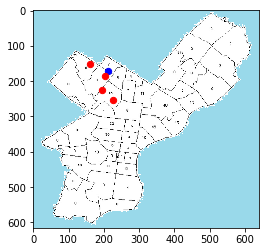

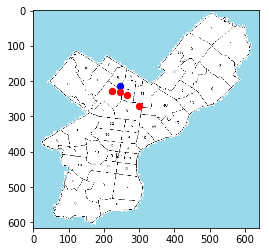

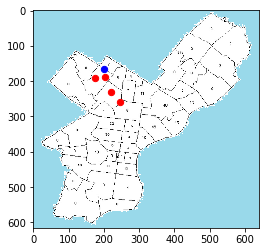

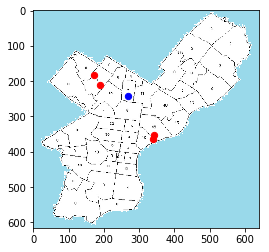

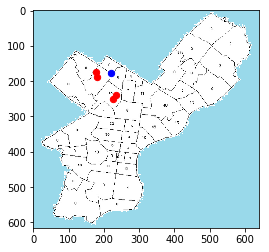

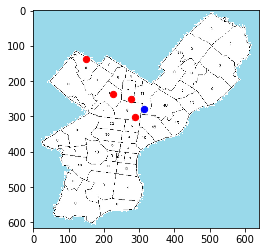

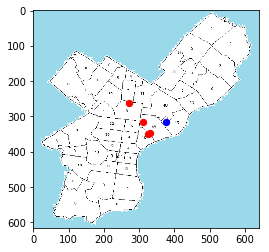

In [81]:
# Generate toy data

#blue: bx = [210]; by= [150]
#red: rx=[320, 280], ry=[300, 330]

for z in zips:
    for i in range(191):
        implot = plt.imshow(im)
        cx = random.randint(200,400)
        cy = cx*random.uniform(0.8,0.9)
        # put a blue dot at (10, 20)
        plt.scatter(cx, cy, c='b', s=40)

        bx = [rand_hot() for i in range(4) ] 
        by = x2y_adjust(bx)

        # put a red dot, size 40, at 2 locations:u
        plt.scatter(bx, by, c='r', s=40)
        plt.savefig(f'data/{z}/text_map{i}.png',dpi=200)

        plt.show()


- Note: Only a few toy data shown since this jupyter notebook became too big to push

In [7]:
# Data processing

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('.',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=10,
                                                 class_mode='categorical',
                                                 shuffle=True)


Found 9008 images belonging to 5 classes.


- Note: BUG! Desired number of classes is 47, the number of zip codes shown on most zip-code-maps
- Possible bug when calling ImageDataGenerator: preprocess_input function from Keras MobileNet model

In [96]:
# Retrain model with new data
deepPhilaOD.fit_generator(generator=train_generator,
                        steps_per_epoch=150,
                        epochs=5)


Epoch 1/5
150/150 [==============================] - 194s 1s/step - loss: 1.1921e-07 - acc: 1.0000
Epoch 2/5
150/150 [==============================] - 180s 1s/step - loss: 1.1921e-07 - acc: 1.0000
Epoch 3/5
150/150 [==============================] - 173s 1s/step - loss: 0.0107 - acc: 0.9993
Epoch 4/5
150/150 [==============================] - 177s 1s/step - loss: 1.1921e-07 - acc: 1.0000
Epoch 5/5
150/150 [==============================] - 176s 1s/step - loss: 1.1921e-07 - acc: 1.0000


- Note: training performed on dummy data is expected to be inaccurate
- Possible explanation: the greatly decreased number of expected categories (47, not 5) might be responsible for the inflated accuracy

## Prediction for a new image

In [ ]:
# New image! 
path_new_im = 'staticmap.png'
im_loaded= image.load_img(path_new_im, target_size=(224, 224))
new_im_a = image.img_to_array( im_loaded )
new_im = np.expand_dims( new_im_a, axis=0 )
new_im = preprocess_input( new_im )

# Prediction
new_pred = deepPhilaOD.predict( new_im )


In [122]:
import pandas as pd
elems = (np.array([1, 2, 3]), np.array([-1, 1, -1])) 
pred_df = pd.DataFrame( new_pred, columns=['19104','19111', '19137','19119','19145'], index = ['Pred_val'])


In [123]:
pred_df


,19104,19111,19137,19119,19145
Pred_val,0.0,0.0,59.910152,0.0,0.0
